## Fully connected and convolutional autoencoder
In this notebook we will train fully connected and convolutional autoencoder on the MNIST dataset, then we will use the "bottleneck"-layer as a feature representation of the data. We will also add noise to the original data with the goal to improve the feature representation. This excercise is inspitend by this Keras blog: https://blog.keras.io/building-autoencoders-in-keras.html 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Loading the MNIST dataset

In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


Flatten the data and normalize it to the 0-1 intervall

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


To speed up computationg we dont use the whole dataset (10k train and 2.5k test)

In [4]:
x_train=x_train[0:10000]
x_test=x_test[0:2500]
print(x_train.shape)
print(x_test.shape)

(10000, 784)
(2500, 784)


In [5]:
import keras
from keras.models import Sequential
from keras.layers import Input,Activation, Dense, Conv2D, MaxPooling2D, UpSampling2D

### fc_autoencoder

In [6]:
name = 'fc_autoencoder'

model = Sequential()
model.add(Dense(32, input_dim=(784),activation='relu',name="bottleneck"))
model.add(Dense(784,activation='sigmoid',name="reconstruction"))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta')

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottleneck (Dense)           (None, 32)                25120     
_________________________________________________________________
reconstruction (Dense)       (None, 784)               25872     
Total params: 50,992.0
Trainable params: 50,992
Non-trainable params: 0.0
_________________________________________________________________


In [8]:
model.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),verbose=2)

Train on 10000 samples, validate on 2500 samples
Epoch 1/100
6s - loss: 0.6738 - val_loss: 0.6106
Epoch 2/100
5s - loss: 0.4465 - val_loss: 0.3277
Epoch 3/100
5s - loss: 0.3013 - val_loss: 0.2852
Epoch 4/100
5s - loss: 0.2836 - val_loss: 0.2766
Epoch 5/100
6s - loss: 0.2778 - val_loss: 0.2714
Epoch 6/100
6s - loss: 0.2743 - val_loss: 0.2679
Epoch 7/100
5s - loss: 0.2714 - val_loss: 0.2655
Epoch 8/100
4s - loss: 0.2686 - val_loss: 0.2626
Epoch 9/100
4s - loss: 0.2657 - val_loss: 0.2593
Epoch 10/100
4s - loss: 0.2625 - val_loss: 0.2568
Epoch 11/100
4s - loss: 0.2589 - val_loss: 0.2534
Epoch 12/100
4s - loss: 0.2551 - val_loss: 0.2497
Epoch 13/100
4s - loss: 0.2512 - val_loss: 0.2468
Epoch 14/100
4s - loss: 0.2473 - val_loss: 0.2430
Epoch 15/100
4s - loss: 0.2436 - val_loss: 0.2396
Epoch 16/100
4s - loss: 0.2401 - val_loss: 0.2370
Epoch 17/100
5s - loss: 0.2368 - val_loss: 0.2335
Epoch 18/100
4s - loss: 0.2337 - val_loss: 0.2309
Epoch 19/100
4s - loss: 0.2308 - val_loss: 0.2280
Epoch 20/1

Extracting the bottleneck features and predicting the reconstruction

In [9]:
from keras.models import Model
model_bottleneck = Model(inputs=model.input, outputs=model.get_layer('bottleneck').output)

In [10]:
representation=model_bottleneck.predict(x_test)

In [11]:
#np.savez("fc_autoencoder_MNIST",representation,y_test)

In [12]:
reconstruction=model.predict(x_test)

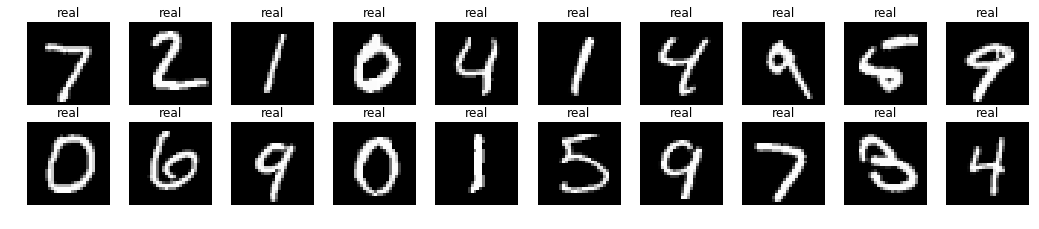

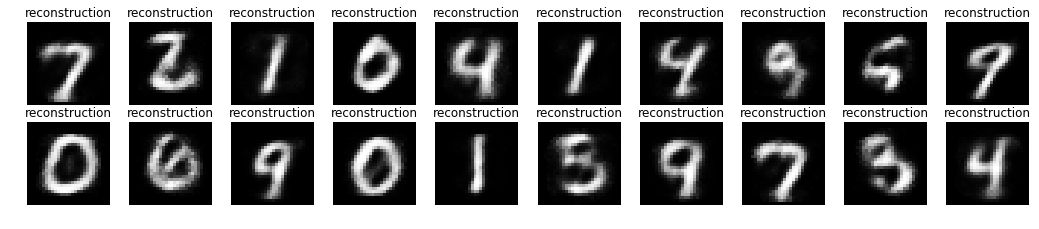

In [13]:
plt.figure(figsize=(18,18))
for i in range(0,20):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(x_test[i].reshape(28,28,1)),cmap="gray")
    plt.axis('off')
    plt.title('real')
    
plt.figure(figsize=(18,18))
for i in range(0,20):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(reconstruction[i].reshape(28,28,1)),cmap="gray")   
    plt.axis('off')
    plt.title('reconstruction')

2D visualization of the representation layer with the corresponding labels

In [14]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne = model.fit_transform(representation) 

In [15]:
y_test=y_test[0:2500]

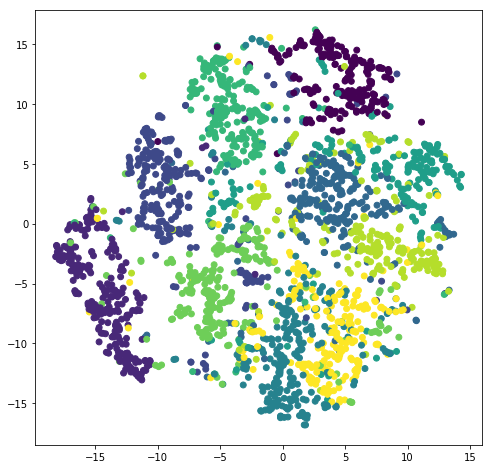

In [16]:
plt.figure(figsize=(8,8))
plt.scatter(x=tsne[:,0],y=tsne[:,1],c=y_test,s=35)

Now we will train the same network as before with noisy train and test data

In [17]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

### fc_autoencoder_denoising

In [18]:
name = 'fc_autoencoder_denoising'

model = Sequential()
model.add(Dense(32, input_dim=(784),activation='relu',name="bottleneck"))
model.add(Dense(784,activation='sigmoid',name="reconstruction"))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta')

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottleneck (Dense)           (None, 32)                25120     
_________________________________________________________________
reconstruction (Dense)       (None, 784)               25872     
Total params: 50,992.0
Trainable params: 50,992
Non-trainable params: 0.0
_________________________________________________________________


In [20]:
model.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),verbose=2)

Train on 10000 samples, validate on 2500 samples
Epoch 1/100
5s - loss: 0.6136 - val_loss: 0.4144
Epoch 2/100
5s - loss: 0.3167 - val_loss: 0.2741
Epoch 3/100
5s - loss: 0.2759 - val_loss: 0.2652
Epoch 4/100
5s - loss: 0.2713 - val_loss: 0.2633
Epoch 5/100
5s - loss: 0.2695 - val_loss: 0.2623
Epoch 6/100
5s - loss: 0.2684 - val_loss: 0.2609
Epoch 7/100
5s - loss: 0.2676 - val_loss: 0.2611
Epoch 8/100
5s - loss: 0.2669 - val_loss: 0.2598
Epoch 9/100
5s - loss: 0.2663 - val_loss: 0.2591
Epoch 10/100
6s - loss: 0.2656 - val_loss: 0.2586
Epoch 11/100
6s - loss: 0.2650 - val_loss: 0.2581
Epoch 12/100
5s - loss: 0.2642 - val_loss: 0.2573
Epoch 13/100
5s - loss: 0.2634 - val_loss: 0.2565
Epoch 14/100
5s - loss: 0.2624 - val_loss: 0.2548
Epoch 15/100
5s - loss: 0.2614 - val_loss: 0.2549
Epoch 16/100
5s - loss: 0.2601 - val_loss: 0.2527
Epoch 17/100
5s - loss: 0.2587 - val_loss: 0.2515
Epoch 18/100
5s - loss: 0.2572 - val_loss: 0.2504
Epoch 19/100
5s - loss: 0.2554 - val_loss: 0.2498
Epoch 20/1

Extracting the bottleneck features and predicting the reconstruction

In [21]:
from keras.models import Model
model_bottleneck = Model(inputs=model.input, outputs=model.get_layer('bottleneck').output)

In [22]:
representation=model_bottleneck.predict(x_test_noisy)

In [23]:
#np.savez("fc_autoencoder_denoising_MNIST",representation,y_test)

In [24]:
reconstruction=model.predict(x_test_noisy)

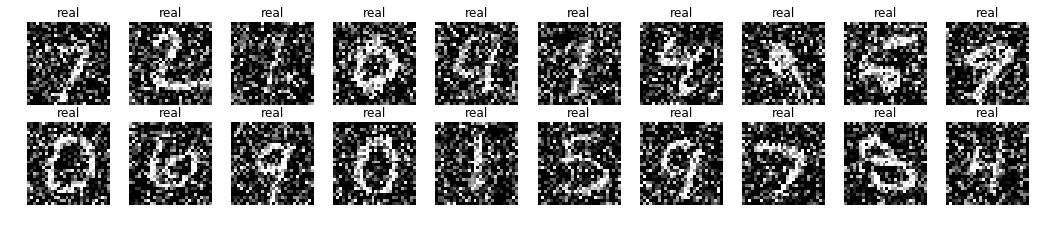

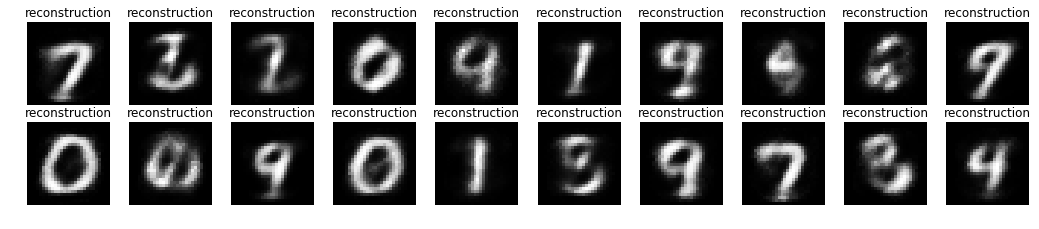

In [25]:
plt.figure(figsize=(18,18))
for i in range(0,20):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(x_test_noisy[i].reshape(28,28,1)),cmap="gray")
    plt.axis('off')
    plt.title('real')
    
plt.figure(figsize=(18,18))
for i in range(0,20):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(reconstruction[i].reshape(28,28,1)),cmap="gray")   
    plt.axis('off')
    plt.title('reconstruction')

2D visualization of the representation layer with the corresponding labels

In [26]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne = model.fit_transform(representation) 

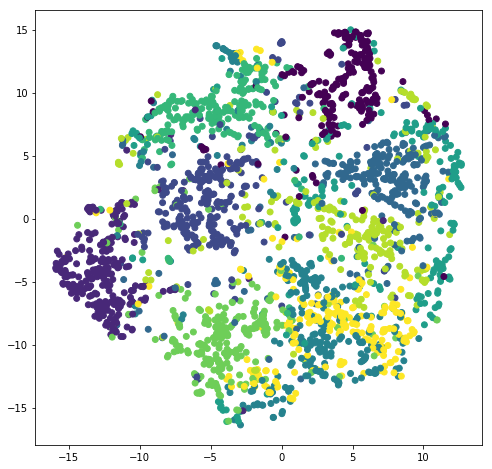

In [27]:
plt.figure(figsize=(8,8))
plt.scatter(x=tsne[:,0],y=tsne[:,1],c=y_test,s=35)

Now lets see how a convolutional autoencoder performs

### cnn_autoencoder

In [28]:
name = 'cnn_autoencoder'
model = Sequential()

model.add(Conv2D(16, (3,3),activation='relu',padding='same',input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(8, (3,3),activation='relu',padding='same'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(8, (3,3),activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(16, (3,3),activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1, (3,3),activation='sigmoid',padding='same'))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta')

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 16)        1168      
__________

Reshape the data to (28,28,1) format

In [30]:
x_train=x_train.reshape(len(x_train),28,28,1)
x_test=x_test.reshape(len(x_test),28,28,1)
x_train_noisy=x_train_noisy.reshape(len(x_train_noisy),28,28,1)
x_test_noisy=x_test_noisy.reshape(len(x_test_noisy),28,28,1)

In [31]:
#model.fit(x_train, x_train,
#                epochs=50,
#                batch_size=256,
#                shuffle=True,
#                validation_data=(x_test, x_test),verbose=2)

In [32]:
#model.save('cnn_autoencoder.h5') 

In [33]:
#here we load the already trained network to save time
from keras.models import load_model
model = load_model('../data/models/cnn_autoencoder.h5')

Extracting the bottleneck features and predicting the reconstruction

In [34]:
from keras.models import Model
model_bottleneck = Model(inputs=model.input, outputs=model.get_layer('conv2d_3').output)

In [35]:
representation=model_bottleneck.predict(x_test)

In [36]:
representation.shape

(2500, 7, 7, 8)

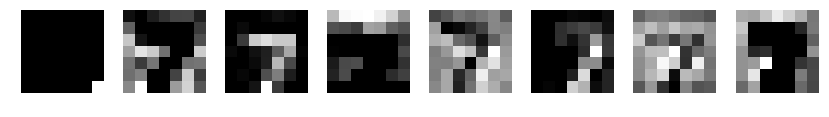

In [37]:
plt.figure(figsize=(18,18))
for i in range(0,8):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(representation[0,:,:,i]),cmap="gray")
    plt.axis('off')

In [38]:
reconstruction=model.predict(x_test)

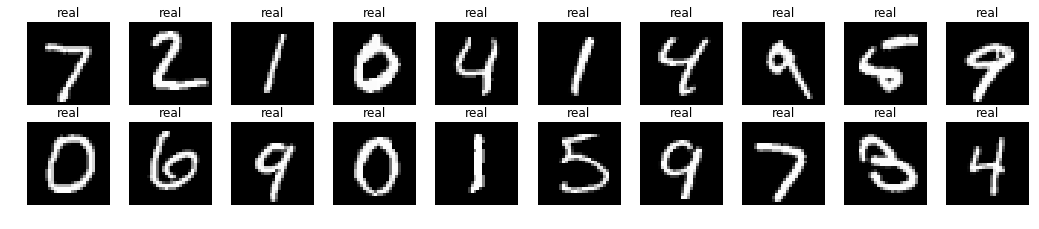

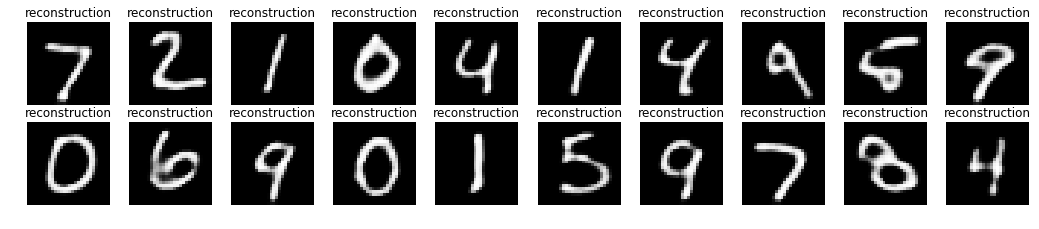

In [39]:
plt.figure(figsize=(18,18))
for i in range(0,20):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(x_test[i]),cmap="gray")
    plt.axis('off')
    plt.title('real')
    
plt.figure(figsize=(18,18))
for i in range(0,20):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(reconstruction[i]),cmap="gray")   
    plt.axis('off')
    plt.title('reconstruction')

2D visualization of the representation layer with the corresponding labels

In [40]:
representation=representation.reshape([len(representation),7*7*8])

In [41]:
#np.savez("cnn_autoencoder_MNIST",representation,y_test)

In [42]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne = model.fit_transform(representation) 

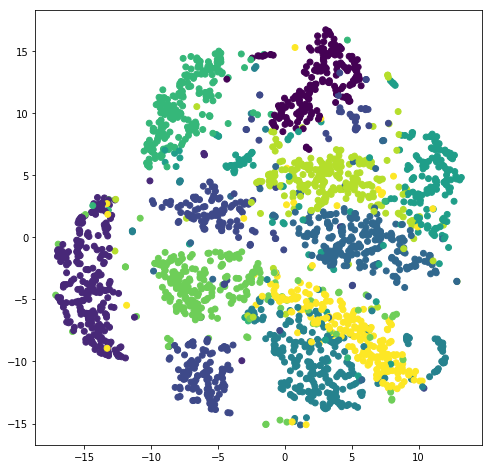

In [43]:
plt.figure(figsize=(8,8))
plt.scatter(x=tsne[:,0],y=tsne[:,1],c=y_test,s=35)

### cnn_autoencoder_denoising

In [44]:
name = 'cnn_autoencoder_denoising'
model = Sequential()

model.add(Conv2D(16,(3,3),activation='relu',padding='same',input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(8,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(8,(3,3),activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(16,(3,3),activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1,(3,3),activation='sigmoid',padding='same'))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta')

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 16)        1168      
__________

In [46]:
#model.fit(x_train_noisy, x_train,
#                epochs=50,
#                batch_size=256,
#                shuffle=True,
#                validation_data=(x_test_noisy,x_test ),verbose=2)

Extracting the bottleneck features and predicting the reconstruction

In [47]:
#model.save('cnn_autoencoder_denoising.h5') 

In [48]:
#here we load the already trained network to save time
from keras.models import load_model
model = load_model('../data/models/cnn_autoencoder_denoising.h5')

In [49]:
from keras.models import Model
model_bottleneck = Model(inputs=model.input, outputs=model.get_layer('conv2d_8').output)

In [50]:
representation=model_bottleneck.predict(x_test_noisy)

In [51]:
representation.shape

(2500, 7, 7, 8)

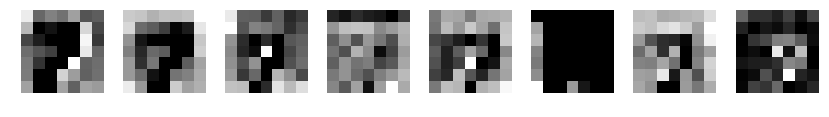

In [52]:
plt.figure(figsize=(18,18))
for i in range(0,8):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(representation[0,:,:,i]),cmap="gray")
    plt.axis('off')

In [53]:
reconstruction=model.predict(x_test_noisy)

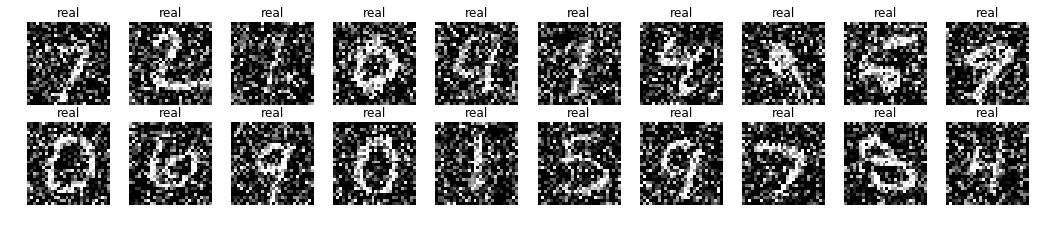

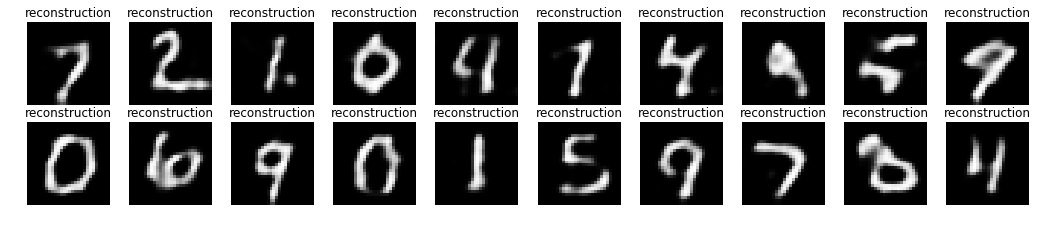

In [54]:
plt.figure(figsize=(18,18))
for i in range(0,20):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(x_test_noisy[i]),cmap="gray")
    plt.axis('off')
    plt.title('real')
    
plt.figure(figsize=(18,18))
for i in range(0,20):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.squeeze(reconstruction[i]),cmap="gray")   
    plt.axis('off')
    plt.title('reconstruction')

2D visualization of the representation layer with the corresponding labels

In [55]:
representation=representation.reshape([len(representation),7*7*8])

In [56]:
#np.savez("cnn_autoencoder_denoiseing_MNIST",representation,y_test)

In [57]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne = model.fit_transform(representation) 

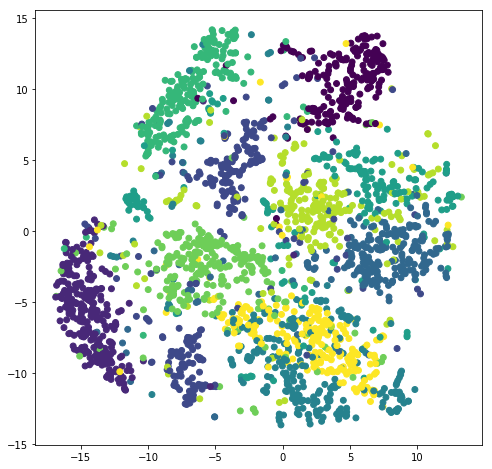

In [58]:
plt.figure(figsize=(8,8))
plt.scatter(x=tsne[:,0],y=tsne[:,1],c=y_test,s=35)

Loading the vgg16 features of the 2.5k MNIST testdata und 2D visualization of the representation layer with the corresponding labels

In [59]:
import urllib
import os
if not os.path.isfile('vgg16_fcl1_MNIST.npz'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/207krpgbyo7hc9u/vgg16_fcl1_MNIST.npz?dl=1",
    "vgg16_fcl1_MNIST.npz")
%ls -hl vgg16_fcl1_MNIST.npz

-rw-r--r-- 1 root root 79M Apr  2 23:51 vgg16_fcl1_MNIST.npz


In [60]:
Data=np.load("vgg16_fcl1_MNIST.npz")
print(Data.files)
representation = Data["arr_0"]
y_test = Data["arr_1"]
representation.shape

['arr_1', 'arr_0']


(2500, 4096)

In [61]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne = model.fit_transform(representation) 

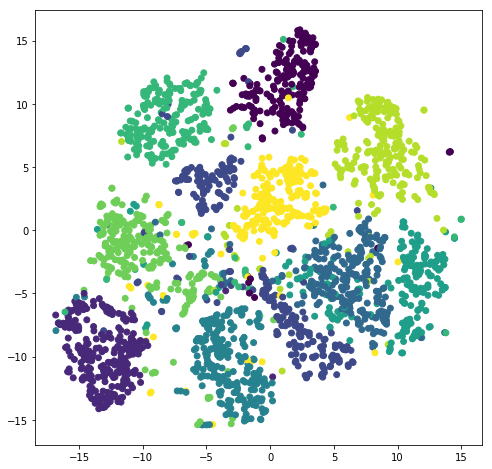

In [62]:
plt.figure(figsize=(8,8))
plt.scatter(x=tsne[:,0],y=tsne[:,1],c=y_test,s=35)